The goal is to classify pairs of sentences as "entailment", "neutral" or "contradiction".
"entailment": one sentence can be deduced from the other.
"contraadiction": One sentence contradicts the other.
"neutral": the sentences do not entail or contradict each others.
    
The idea is to compute a similarity score between the sentences to then classify them in one of the 3 categories.
The sentence simiralirity score will be based on words similarity scores:
for each word in the sentence, we will compute a similaritry score with every other word in the sentence.

We will use simple NN, that we will feed with word vectors from a pretrained Glove dataset.

# Loading Glove vectors

We use Glove vectors as the input of our NN.
Those functions help manipulate (read) this dataset.

In [1]:
import numpy as np
import torch
from torch.autograd import Variable

glove_path = "NLI/glove.6B/glove.6B.200d.txt"


def load_glove_embeddings(path, word2idx, embedding_dim=50):
    with open(path) as f:
        embeddings = np.zeros((len(word2idx), embedding_dim))
        for line in f.readlines():
            values = line.split()
            word = values[0]
            index = word2idx.get(word)
            if index:
                vector = np.array(values[1:], dtype='float32')
                embeddings[index] = vector
        return torch.from_numpy(embeddings).float()

def load_glove(path,limit=1000000000):
    with open(path) as f:
        glove = {}
        i = 0
        for line in f.readlines():
            if i < limit:
                values = line.split()
                word = values[0]
                my_array = [float(x) for x in values[1:]]
                #normalize to l2 = 1
                norm2 = np.linalg.norm(np.array(my_array),2)
                my_array = my_array / norm2
                vector = torch.FloatTensor([my_array])
                # vector = Variable(vector)
                glove[word] = vector
            else:
                break
            i += 1
        return glove

print("...loading glove")
glove = load_glove(path=glove_path)
print("Loaded %d word vectors from Glove"%len(glove))

...loading glove
Loaded 400000 word vectors from Glove


# SNLI dataset

## Loading SNLI dataset

In [2]:
import json

SNLI_path = "NLI/snli_1.0/snli_1.0_train.jsonl"

def loadSNLI(path,limit=100000000000):
    print("...loading SNLI dataset")
    SNLI_train = list()
    i = 0
    for line in open(path, 'r'):
        if i <limit:
            data = json.loads(line)
            if data['gold_label'] != '-':
                SNLI_train.append(data)
                i += 1
        else:
            print("Loaded %d pairs of sentences from SNLI dataset"%len(SNLI_train))
            return SNLI_train
    print("Loaded %d pairs of sentences from SNLI dataset"%len(SNLI_train))
    return SNLI_train

In [302]:
SNLI_train = loadSNLI(SNLI_path)

...loading SNLI dataset
Loaded 549367 pairs of sentences from SNLI dataset


## Preprocessing SNLI dataset

Tokenize + get word vectors.

### Tokenize dataset

We need to tokenize the dataset: string sentence --> list of words sentence.
The OOV class will help determine if a word is OOV and keep track of the number of OOV words in our dataset.

In [3]:
class OOV:
	def __init__(self,glove):
		self.OOVlist = list()
		self.numberOfPairsWithOOV = 0
		self.wordVectors = glove

	def getData(self):
		# print(self.OOVlist)
		return len(self.OOVlist), self.numberOfPairsWithOOV

	def countOOVinCorpus(self,sentence):
		b = False
		for word in sentence:
			if self.isOOV(word) and word not in self.OOVlist:
				self.OOVlist.append(word)
				b = True
		self.numberOfPairsWithOOV += 1 if b else 0

	def isOOV(self,word):
		vect = self.wordVectors.get(word)
		try:
			_ = vect.shape
		except AttributeError:
			# print("Could not find vector for "+word)
			return True
		return False

We define helper functions to tokenize the dataset.

In [4]:
import re

def processFinalPeriod(sentence1):
	if (sentence1[len(sentence1)-1] == "."):
		sentence1 = sentence1[:len(sentence1)-2] + " ."

def insertCharIfSeq(sentence1,c,seq):
	i = 0
	indexes = [m.start() for m in re.finditer(seq, sentence1)]
	for index in indexes:
		sentence1 = sentence1[:index+i] + c + sentence1[index+i:]
		i += 1
	return sentence1

def processContractions(sentence1):
	sentence1 = insertCharIfSeq(sentence1," ","'s")
	sentence1 = insertCharIfSeq(sentence1," ","'m")
	sentence1 = insertCharIfSeq(sentence1," ","'ll")
	sentence1 = insertCharIfSeq(sentence1," ","'ve")
	sentence1 = insertCharIfSeq(sentence1," ","'re")
	sentence1 = insertCharIfSeq(sentence1," ","'d")
	return sentence1


def processNegatives(sentence1):
	i = 0
	indexes = [m.start() for m in re.finditer("can't", sentence1)]
	for index in indexes:
		sentence1 = sentence1[:index+i+3] + sentence1[index+i+2:]
		i += 1
	return insertCharIfSeq(sentence1," ","n't")

def processHyphenIfUnknownWords(words,glove):	
	indexes = []
	new_words = []
	i = 0
	myOOV = OOV(glove)
	for w in words:
		if "-" in w and myOOV.isOOV(w):
			indexes.append(i)
			new_words += w.split("-")
			i += 3
		else:
			i += 1
	i = 0
	for i in range(len(indexes)):
		index = indexes[i]
		del words[index]
		# print (words)
		words.insert(index,new_words[i*2])
		words.insert(index+1,"-")
		words.insert(index+2,new_words[i*2+1])
	return words

def tokeniszeSentence(sentence1,glove):
	processFinalPeriod(sentence1)
	sentence1 = processContractions(sentence1)
	sentence1 = processNegatives(sentence1)
	s = sentence1.lower()
	s = re.sub('''([.,!'"?$;:/#`()])''', r' \1 ', s)
	s = re.sub('\s{2,}', ' ', s)
	s = s.split()
	s = processHyphenIfUnknownWords(s,glove)
	s.append('</s>')
	s = ['<s>'] + s
	return s

def testTokenizeSentence():
	sentence1 = "I can't open the door because the 30-year old/blond-hair guy doesn't want to let me in. He's mean, isn't he? I can't go in! There's not other way!"
	# sentence1= "red-hair blond-hair noisette black-hair"
	words = tokeniszeSentence(sentence1,glove)
	print(words)
    
testTokenizeSentence()
myOOV = OOV(glove)

['<s>', 'i', 'can', 'n', "'", 't', 'open', 'the', 'door', 'because', 'the', '30-year', 'old', '/', 'blond', '-', 'hair', 'guy', 'does', 'n', "'", 't', 'want', 'to', 'let', 'me', 'in', '.', 'he', "'", 's', 'mean', ',', 'is', 'n', "'", 't', 'he', '?', 'i', 'can', 'n', "'", 't', 'go', 'in', '!', 'there', "'", 's', 'not', 'other', 'way', '!', '</s>']


### Tokenizing and getting word vectors for dataset

In [5]:
def tokenizeDataset(dataset):
    print("...tokenizing and getting word embeddings for SNLI dataset")
    sentencesOOVwords = 0
    OOVwords = []
    dataset_tokenized = dict()
    for i in range(len(dataset)):
        # if i<15:
        sentence1 = tokeniszeSentence(dataset[i]["sentence1"],glove)
        sentence2 = tokeniszeSentence(dataset[i]["sentence2"],glove)
        dataset_tokenized[i]=dict()
        dataset_tokenized[i]["sentence1"] = sentence1
        dataset_tokenized[i]["sentence2"] = sentence2
        myOOV.countOOVinCorpus(sentence1+sentence2)
    
    nOOVWwords, nPairsOOVwords = myOOV.getData()
    print("%d OOV words"%nOOVWwords)
    print("%d pairs of sentences have OOV words for a total of %d sentence pairs" 
          %(nPairsOOVwords,len(dataset)))
    
    return dataset_tokenized

In [44]:
import random

def semiSort(SNLI):
    SNLI_len10, SNLI_len20, SNLI_len30, SNLI_len40, SNLIlen50, SNLI_long = [], [], [], [], [], []
    for i in range(len(SNLI)):
        l1, l2 = len(SNLI[i]['sentence1']), len(SNLI[i]['sentence2'])
        l = l1 if l1>l2 else l2
        if l<10:
            SNLI_len10.append(SNLI[i])
        elif l<20:
            SNLI_len20.append(SNLI[i])
        elif l<50:
            SNLI_len30.append(SNLI[i])
        elif l<50:
            SNLI_len40.append(SNLI[i])
        elif l<50:
            SNLI_len50.append(SNLI[i])
        elif l<50:
            SNLI_long.append(SNLI[i])
    return SNLI_len10 + SNLI_len20 + SNLI_len30 + SNLI_len40 + SNLIlen50 + SNLI_long

def loadAndPreprocessDataset(path):
    SNLI = loadSNLI(path)
    random.shuffle(SNLI)
    SNLI = semiSort(SNLI)
    tokenized_SNLI = tokenizeDataset(SNLI)
    return SNLI, tokenized_SNLI    

In [45]:
SNLI_train, SNLI_train_tokenized = loadAndPreprocessDataset('NLI/snli_1.0/snli_1.0_train.jsonl')

...loading SNLI dataset
Loaded 549367 pairs of sentences from SNLI dataset
...tokenizing and getting word embeddings for SNLI dataset
6159 OOV words
6023 pairs of sentences have OOV words for a total of 157582 sentence pairs


In [48]:
for i in  range(5):
    print(SNLI_train[i]['sentence1'])
    print(SNLI_train[i]['sentence2'])
    print(SNLI_train[i]['gold_label'])

a cyclist
A biker
entailment
A dog in a field.
A dog is outdoors.
entailment
Two wet dogs.
two dogs in rain
neutral
A dog in a field.
a cat in a hamock
contradiction
A baby is laughing.
A baby is crying.
contradiction


### Feedind sentences to tensors

In [8]:
def sentenceTo2DTensor(sentence, embeddings, size=None):
    if (not size) :
        size = len(sentence)
    V1 = torch.zeros(size,200)
    for i, w1 in enumerate(sentence):
        v1 = embeddings.get(w1) if w1 not in myOOV.OOVlist else torch.FloatTensor([np.random.rand(1,200)])
        V1[i] = v1
    return V1

def sentenceTo3DTensor(sentence,embeddings):
    V1 = torch.zeros(1,len(sentence),200)
    V1[0] = sentenceTo2DTensor(sentence,embeddings)
    return Variable(V1)

def batchesSentencesToTensors(start,size,dataset,embeddings):
    maxlength = 0
    for i in range(start,start+size):
        l1, l2 = len(dataset[i]['sentence1']), len(dataset[i]['sentence2'])
        l = l1 if l1>l2 else l2
        maxlength = l if l>maxlength else maxlength
    Va = torch.zeros(size,maxlength,200)
    Vb = torch.zeros(size,maxlength,200)
    lengths = []
    for i in range(start,start+size):
        sentence1, sentence2 = dataset[i]['sentence1'], dataset[i]['sentence2']
#         print(sentence1,sentence2)
        Va[i-start], Vb[i-start] = sentenceTo2DTensor(sentence1,embeddings,maxlength), sentenceTo2DTensor(sentence2,embeddings,maxlength)
        lengths.append((len(sentence1),len(sentence2)))
    Va, Vb = Variable(Va), Variable(Vb)
    
    return Va, Vb, lengths
        
    
s1 = SNLI_train_tokenized[5]["sentence1"]
print(s1)
V1 = sentenceTo3DTensor(s1,glove) 
print(V1.size())
Va, Vb, lengths = batchesSentencesToTensors(6,4,SNLI_train_tokenized,glove)
sa = Va.size()
print(sa,Vb.size())
print(lengths)
print(Va[:,sa[1]-3:,198:])

['<s>', 'children', 'smiling', 'and', 'waving', 'at', 'camera', '</s>']
torch.Size([1, 8, 200])
torch.Size([4, 29, 200]) torch.Size([4, 29, 200])
[(16, 9), (16, 9), (16, 9), (29, 19)]
Variable containing:
(0 ,.,.) = 
  0.0000  0.0000
  0.0000  0.0000
  0.0000  0.0000

(1 ,.,.) = 
  0.0000  0.0000
  0.0000  0.0000
  0.0000  0.0000

(2 ,.,.) = 
  0.0000  0.0000
  0.0000  0.0000
  0.0000  0.0000

(3 ,.,.) = 
 -0.0107 -0.0589
 -0.0331 -0.0197
  0.3436  0.0026
[torch.FloatTensor of size 4x3x2]



In [10]:
all_categories = ['entailment', 'neutral', 'contradiction']

import random

def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1)
    category_i = top_i[0]
    return all_categories[category_i], category_i

# print(categoryFromOutput(output[0]))

def getTrainingExample(dataset,dataset_tokenized,i):
    category = dataset[i]["gold_label"]
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    s1, s2 = dataset[i]["sentence1"], dataset[i]["sentence2"]
    x1, x2 = dataset_tokenized[i]["sentence1"], dataset_tokenized[i]["sentence2"]
    a, b = sentenceTo3DTensor(x1,glove), sentenceTo3DTensor(x2,glove)
    return category, s1, s2, category_tensor, a, b

def randomTrainingExample(dataset,dataset_tokenized):
    i = random.randint(0,len(dataset)-1)
    category, s1, s2, category_tensor, a, b = getTrainingExample(dataset,dataset_tokenized,i)
    return category, s1, s2, category_tensor, a, b

def getTrainingBatch(start,size,dataset,dataset_tokenized,embeddings):
    A, B, l = batchesSentencesToTensors(start,size,dataset_tokenized,embeddings)
    array = np.zeros(size)
    C = torch.LongTensor(array)
    for i in range(start,start+size):
        category = dataset[i]["gold_label"]
        C[i-start] = all_categories.index(category)
    return Variable(C), A, B

for j in range(0,3):
    category, s1, s2, category_tensor, a, b = randomTrainingExample(SNLI_train,SNLI_train_tokenized)
    print(s1,s2,category)
    
C, A, B = getTrainingBatch(4,4,SNLI_train,SNLI_train_tokenized,glove)
print(A.size(),B.size(),C.size())

A man looks at the camera as he holds a small soldering iron near a magnifying glass and circuit board. A man looking at the internal components of a camera. entailment
A group of friends are deciding what they should eat today. Some people are gathered at a table. entailment
Four men play a frisbee game on a grass field. Four men play a game. entailment
torch.Size([4, 16, 200]) torch.Size([4, 16, 200]) torch.Size([4])


### Preparing training, dev and test sets TODO

+ cf paper (padding, semi sorting, etc)

# Neural Network

## Creating the network

In [166]:
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

D_IN = 200
D_HIDDEN = 200
D_OUT_MLP = 1
D_OUT = 3

class NN(nn.Module):
    def __init__(self,dropout_ratio=0.2,d_in=D_IN,d_out=D_OUT,d_hidden=D_HIDDEN):
#                  d_out_mlp = D_OUT_MLP):
        super(NN, self).__init__()
        n = 0.01
        self.MLP1_h1 = nn.Linear(d_in,d_hidden)
#         self.MLP1_h1.weight.data.normal_(-n,n)
#         self.MLP1_h2 = nn.Linear(d_hidden,d_hidden)
#         self.MLP1_h2.weight.data.normal_(-n,n)   
        
        self.MLP2_h1 = nn.Linear(d_in*2,d_hidden)
#         self.MLP2_h1.weight.data.normal_(-n,n)
#         self.MLP2_h2 = nn.Linear(d_hidden,d_hidden)
#         self.MLP2_h2.weight.data.normal_(-n,n)
        
        self.MLP3_h1 = nn.Linear(d_in*2,d_hidden)
#         self.MLP3_h1.weight.data.normal_(-n,n)
#         self.MLP3_h2 = nn.Linear(d_hidden,d_hidden)
#         self.MLP3_h2.weight.data.normal_(-n,n)
        self.MLP3_out = nn.Linear(d_hidden,d_out)
#         self.MLP3_out.weight.data.normal_(-n,n)
        
        self.MLP_drop = nn.Dropout(p=dropout_ratio)
        
        self.logSoftmax = nn.LogSoftmax(dim=1)
        self.softmaxCol = nn.Softmax(0)
        self.softmaxLine = nn.Softmax(1)
        
    def forward(self,a,b):
        
        # MLP1 (F)
        
        Fa = F.relu(self.MLP1_h1(a))
        Fa = self.MLP_drop(Fa)
#         Fa = F.relu(self.MLP1_h2(Fa))
#         Fa = self.MLP1_out(Fa)        
        Fb = F.relu(self.MLP1_h1(b))
        Fb = self.MLP_drop(Fb)
#         Fb = F.relu(self.MLP1_h2(Fb))
#         Fb = self.MLP1_out(Fb)
        
        # Attend
        
        # Attention eight matrix
        Fb = Fb.permute(0,2,1)
        E = torch.bmm(Fa,Fb)
        # Normalize attention wights
        E_softmaxCol = self.softmaxCol(E)
        E_softmaxLine = self.softmaxLine(E).permute(0,2,1)  
        # Softly aligned subphrases
        beta = torch.bmm(E_softmaxCol,b) # subphrase b aligned with a
        alpha = torch.bmm(E_softmaxLine,a) # subphrase a aligned with b
                
        # MLP2 (G)
        
        aBeta = torch.cat([a,beta],2)
        bAlpha = torch.cat([b,alpha],2)
        v1 = F.relu(self.MLP2_h1(aBeta))  
        v1 = self.MLP_drop(v1)
#         v1 = F.relu(self.MLP2_h2(v1))
        v2 = F.relu(self.MLP2_h1(bAlpha))
        v2 = self.MLP_drop(v2)
#         v2 = F.relu(self.MLP2_h2(v2))
        
        # Aggregate
        v1 = torch.sum(v1,1)
        v2 = torch.sum(v2,1)
                
        # MLP3 (H)
        y = torch.cat([v1,v2],1)

#         Fa = torch.sum(Fa,0)
#         Fa = Fa.unsqueeze(0)
#         Fb = torch.sum(Fb,0)
#         Fb = Fb.unsqueeze(0)
#         y = torch.cat([Fa,Fb],1)

        y = self.MLP3_h1(y)
        y = self.MLP_drop(y)
        y = F.relu(y)
#         y = F.relu(self.MLP3_h2(y))
        y = self.MLP3_out(y)    
        y = self.logSoftmax(y)
        
        
        return y
    
network = NN()

# s1, s2 = SNLI_train_tokenized[0]["sentence1"], SNLI_train_tokenized[0]["sentence2"]
# a, b = sentenceToTensor(s1,glove), sentenceToTensor(s2,glove)
# o = network(a,b)
# print(o)

Va, Vb, l = batchesSentencesToTensors(0,4,SNLI_train_tokenized,glove)
print(Va.size(),Vb.size())
output = network(Va,Vb)
print(output)

torch.Size([4, 8, 200]) torch.Size([4, 8, 200])
Variable containing:
-1.1249 -1.3312 -0.8888
-1.0459 -1.5082 -0.8502
-1.1967 -1.4347 -0.7774
-1.1217 -1.2129 -0.9757
[torch.FloatTensor of size 4x3]



## TODO
+ check Agrad optimization
+ default initial accumulator vvalue 0.1


# Training

## Training process

In [171]:
criterion = nn.NLLLoss()
learning_rate = 0.025

def trainingStep(learning_rate, sentence1Tensor, sentence2Tensor, category_tensor):
    network.zero_grad()
    output = network(sentence1Tensor,sentence2Tensor)
    loss = criterion(output, category_tensor)    
    loss.backward()    
    for p in network.parameters():
#         print('new p')
#         print(p.size())
        p.data.add_(-learning_rate, p.grad.data)        
    return output, loss.data[0], p.grad.data


# output, loss, grad = train(a,b,category_tensor)
output, loss, grad = trainingStep(learning_rate,A,B,C)
print(output,loss)

Variable containing:
-0.8197 -4.5017 -0.6009
-1.7367 -3.9761 -0.2167
-1.4263 -4.9519 -0.2841
-0.4610 -3.9272 -1.0509
[torch.FloatTensor of size 4x3]
 0.4453611969947815


## Training the network

In [176]:
start = time.time()

In [179]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    h = math.floor(s/(60*60))
    s = s - h*60*60
    m = math.floor(s/60)
    s -= m*60
    return '%dh %dm %ds'%(h,m,s)

timeSince(start)

'0h 1m 52s'

In [203]:
def train(network,n_iters,learning_rate,batch_size,dropout_ratio,print_every_bool=False):

    print_every = n_iters/100*10
    plot_every = print_every/10
    
    # keep track of losses for ploting
    current_loss = 0
    all_losses = []
    
    s = time.time()
#     network = NN(dropout_ratio)
    
    it = 1
    last_print, last_plot = 0, 0

    while it<n_iters+1:
    #     category, s1, s2, category_tensor, a, b = randomTrainingExample(SNLI_train,SNLI_train_tokenized)
        if batch_size >1:
            start = it%lenSNLI
            start = 1 if (start + batch_size)>=lenSNLI else start
            category_tensor, A, B = getTrainingBatch(start,batch_size,SNLI_train,SNLI_train_tokenized,glove)
        else:
            category, s1, s2, category_tensor, A, B = getTrainingExample(SNLI_train,SNLI_train_tokenized,it%lenSNLI)
        output, loss, grad = trainingStep(learning_rate,A,B,category_tensor)
        current_loss += loss

        if print_every_bool and int(it/print_every)>last_print:
            last_print += 1
            category, s1, s2, category_tensor, a, b = randomTrainingExample(SNLI_train,SNLI_train_tokenized)
#             print(a.size(),b.size())
            output = network(a,b)
            guess, guess_i = categoryFromOutput(output[0])
            correct = '✓' if guess == category else '✗ (%s)' % category
            print ('%d %d%% (%s) %.6f %.6f'
                   %(it, it/n_iters*100, timeSince(s), current_loss, loss))
            print(s1)
            print(s2)
            print('%s %s'%(guess,correct))
            print(network.MLP1_h1.weight.data[0][0:5])

        if int(it/plot_every) > last_plot:
            last_plot += 1
            l = current_loss / plot_every
            all_losses.append(l)
            current_loss = 0
            
        it += batch_size
            
    return all_losses

start = time.time()
all_losses = train(network,100000,0.01,128,0.1,print_every_bool=True)

10113 10% (0h 0m 30s) 8.024790 0.992082
Construction men setting up train tracks.
A house is being built.
contradiction ✓

1.00000e-02 *
  1.2664
  1.1924
  5.9877
  5.8416
 -2.6126
[torch.FloatTensor of size 5]

20097 20% (0h 1m 1s) 7.857378 1.023414
Boys play cricket on a field.
Small boys play a game.
entailment ✗ (neutral)

1.00000e-02 *
  1.2679
  1.1910
  5.9854
  5.8411
 -2.6138
[torch.FloatTensor of size 5]

30081 30% (0h 1m 31s) 7.632391 0.926153
These two people are eating.
There are people eating.
entailment ✓

1.00000e-02 *
  1.2685
  1.1927
  5.9852
  5.8406
 -2.6148
[torch.FloatTensor of size 5]

40065 40% (0h 2m 2s) 7.719379 0.999412
Uniformed children playing soccer
Children play soccer.
entailment ✓

1.00000e-02 *
  1.2704
  1.1951
  5.9855
  5.8413
 -2.6165
[torch.FloatTensor of size 5]

50049 50% (0h 2m 32s) 7.489885 0.963024
Three passengers on a train car.
They are in a train.
entailment ✓

1.00000e-02 *
  1.2722
  1.1959
  5.9834
  5.8402
 -2.6186
[torch.FloatTens

## Plot losses

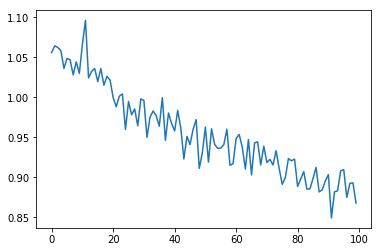

In [188]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

# Evaluate network

In [74]:
def evaluatingStep(sentence1Tensor, sentence2Tensor, category_tensor):
    network.zero_grad()
    output = network(sentence1Tensor,sentence2Tensor)
    return output

In [82]:
SNLI_test, SNLI_test_tokenized = loadAndPreprocessDataset('NLI/snli_1.0/snli_1.0_test.jsonl')

...loading SNLI dataset
Loaded 9824 pairs of sentences from SNLI dataset
...tokenizing and getting word embeddings for SNLI dataset
6159 OOV words
6023 pairs of sentences have OOV words for a total of 2433 sentence pairs


In [201]:
n_categories = len(all_categories)

#keep track of correct guesses in confusion matrix
def evaluate(network,dataset,dataset_tokenized,batch_size=128,print_every_bool=False):
    confusion = torch.zeros(n_categories, n_categories)
    len_dataset = len(dataset)
    print_every = len_dataset/10

    it = 1
    total_correct = 0
    # Go through examples and record which are guessed correctly
    while it<len_dataset:
        if batch_size >1:
            start = it%len_dataset
            start = 1 if (start + batch_size)>=len_dataset else start
            category_tensor, A, B = getTrainingBatch(start,batch_size,dataset,dataset_tokenized,glove)
        else:
            category, s1, s2, category_tensor, A, B = getTrainingExample(dataset,dataset_tokenized,it%len_dataset)
        output = evaluatingStep(A,B,category_tensor)
        for i in range(output.size()[0]):
            guess, guess_i = categoryFromOutput(output[i])
            category_i = int(category_tensor[i])
            confusion[category_i][guess_i] += 1
            total_correct += 1 if (category_i == guess_i) else 0
        it += batch_size
        
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    acc = total_correct / len_dataset 
    
    return acc

acc = evaluate(network,SNLI_dev,SNLI_dev_tokenized,batch_size=1,print_every_bool=True)
print('Overall accrucary: %.2f%%'%(acc*100))

Overall accrucary: 58.16%


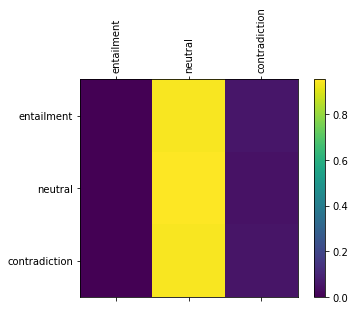

In [204]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

## Development - Getting best batch size, learning rate and dropout ratio

In [126]:
SNLI_dev, SNLI_dev_tokenized = loadAndPreprocessDataset('NLI/snli_1.0/snli_1.0_dev.jsonl')

...loading SNLI dataset
Loaded 9842 pairs of sentences from SNLI dataset
...tokenizing and getting word embeddings for SNLI dataset
6180 OOV words
6044 pairs of sentences have OOV words for a total of 2366 sentence pairs


In [197]:
learning_rates = [0.1,0.3,0.6,1] 
# batch_sizes = [1,2,4,8,16,32,64,128]
dropout_ratios = [0.1,0.2,0.3,0.4,0.5]
n_iters = 100000

lenSNLI = len(SNLI_train)
all_losses = {}
accuracies = {}

s = time.time()

for lr in learning_rates:
    all_losses[lr] = {}
    accuracies[lr] = {}
    for dropout_r in dropout_ratios:
        network = NN(dropout_r)
        all_losses[lr][dropout_r] = train(network,n_iters,lr,1,dropout_r)  
        accuracies[lr][dropout_r] = evaluate(network,SNLI_dev,SNLI_dev_tokenized,batch_size=1,print_every_bool=False)
        print('(%s) Learning Rate: %.3f, dropout ratio: %.2f --> Accuracy: %.2f%%'
                  %(timeSince(s),lr,dropout_r,accuracies[lr][dropout_r]*100))
        

(0h 10m 5s) Learning Rate: 0.100, dropout ratio: 0.10 --> Accuracy: 35.93%
(0h 20m 9s) Learning Rate: 0.100, dropout ratio: 0.20 --> Accuracy: 33.85%
(0h 30m 24s) Learning Rate: 0.100, dropout ratio: 0.30 --> Accuracy: 33.85%
(0h 40m 43s) Learning Rate: 0.100, dropout ratio: 0.40 --> Accuracy: 33.85%
(0h 51m 2s) Learning Rate: 0.100, dropout ratio: 0.50 --> Accuracy: 33.85%
(1h 1m 21s) Learning Rate: 0.300, dropout ratio: 0.10 --> Accuracy: 33.85%
(1h 11m 33s) Learning Rate: 0.300, dropout ratio: 0.20 --> Accuracy: 33.85%
(1h 21m 46s) Learning Rate: 0.300, dropout ratio: 0.30 --> Accuracy: 35.93%
(1h 32m 1s) Learning Rate: 0.300, dropout ratio: 0.40 --> Accuracy: 33.85%
(1h 42m 8s) Learning Rate: 0.300, dropout ratio: 0.50 --> Accuracy: 33.85%
(1h 52m 27s) Learning Rate: 0.600, dropout ratio: 0.10 --> Accuracy: 33.85%
(2h 2m 47s) Learning Rate: 0.600, dropout ratio: 0.20 --> Accuracy: 33.85%
(2h 12m 53s) Learning Rate: 0.600, dropout ratio: 0.30 --> Accuracy: 33.85%
(2h 23m 0s) Learnin

## Retrain best models on more iterations

In [205]:
best_models = [(0.006,0.1),(0.006,0.2),(0.01,0.2),(0.01,0.3),(0.01,0.4)]
n_iters = 100000*5

lenSNLI = len(SNLI_train)
all_losses = {}
accuracies = {}

s = time.time()

for lr, dropout_r in best_models:
    network = NN(dropout_r)
    all_losses[(lr,dropout_r)] = train(network,n_iters,lr,1,dropout_r)  
    accuracies[(lr,dropout_r)] = evaluate(network,SNLI_dev,SNLI_dev_tokenized,batch_size=1,print_every_bool=False)
    print('(%s) Learning Rate: %.3f, dropout ratio: %.2f --> Accuracy: %.2f%%'
              %(timeSince(s),lr,dropout_r,accuracies[(lr,dropout_r)]*100))

(0h 50m 45s) Learning Rate: 0.006, dropout ratio: 0.10 --> Accuracy: 72.40%
(18h 26m 25s) Learning Rate: 0.006, dropout ratio: 0.20 --> Accuracy: 70.50%
(19h 17m 33s) Learning Rate: 0.010, dropout ratio: 0.20 --> Accuracy: 71.85%
(20h 8m 31s) Learning Rate: 0.010, dropout ratio: 0.30 --> Accuracy: 68.93%
(20h 59m 15s) Learning Rate: 0.010, dropout ratio: 0.40 --> Accuracy: 68.26%
